In [ ]:
# Please upload data and unzip the file first
data_path = "./LST20_Corpus"
# Please create the folder before saving the data
store_path = "./data/lst"

# LST20

In [ ]:
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
def read_data(source):
    sen_num = 0
    cls_num = 0
    doc_num = 0
    data = [] # [ 
    #     [ 
    #         [ 
    #             token, 
    #             ... 
    #         ], sent
    #         ...
    #     ], file
    #     ...
    # ]
    word_per_sent = []
    sent_per_data = []
    for root, subdirs, files in os.walk(f"{data_path}/{source}"):
        for name in tqdm(files):
            if name[:2] != '._':
                with open(f"{data_path}/{source}/{name}") as f:
                    tokens = []
                    sents = []
                    sent = []
                    for line in f:
                        line = line.strip()
                        token = line.split('\t')
                        if len(token) == 1:
                            # contain only new line (sentence boundary)
                            sen_num += 1
                            word_per_sent.append(len(sent))
                            sents.append(sent)
                            sent = []
                        else:
                            if token[-1] == 'B_CLS':
                                cls_num += 1
                            sent.append(token)
                    sent_per_data.append(len(sents))
                    data.append(sents)
                    doc_num += 1
    return data, word_per_sent, sent_per_data, sen_num, cls_num, doc_num

## Statistics

In [ ]:
data, word_per_sent, sent_per_data, sen_num, cls_num, doc_num = read_data("train")

100%|██████████| 7588/7588 [00:04<00:00, 1566.04it/s]


In [ ]:
print("Number of clauses:", cls_num)
print("Number of sentences:", sen_num)
print("Number of documents:", doc_num)

Number of clauses: 215301
Number of sentences: 63310
Number of documents: 3794


<ipython-input-6-50434f2f304f>:7: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
  plt.ylim(0, max(n) + 10000)


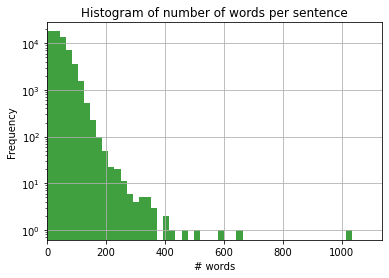

In [ ]:
# the histogram of the number of words per sentence
n, bins, patches = plt.hist(word_per_sent, 50, facecolor='g', alpha=0.75, log=True)
plt.xlabel('# words')
plt.ylabel('Frequency')
plt.title('Histogram of number of words per sentence')
plt.xlim(0, max(bins) + 100)
plt.ylim(0, max(n) + 10000)
plt.grid(True)
plt.show()

<ipython-input-7-73694882791d>:7: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
  plt.ylim(0, max(n) + 1000)


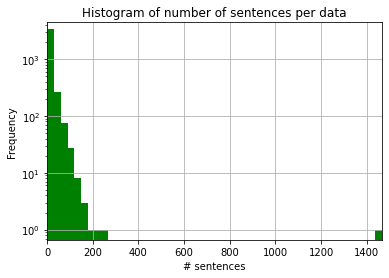

In [ ]:
# the histogram of the number of sentences per data
n, bins, patches = plt.hist(sent_per_data, 50, facecolor='g', alpha=1, log=True)
plt.xlabel('# sentences')
plt.ylabel('Frequency')
plt.title('Histogram of number of sentences per data')
plt.xlim(0, max(bins))
plt.ylim(0, max(n) + 1000)
plt.grid(True)
plt.show()

## Preprocess

In [ ]:
sentence_leng_threshold = 100
min_sent_num = 2
max_sent_num = 10

In [ ]:
def prepare_data(data):
    '''Filter too long sentence and chunk 10 sentences for each instance'''
    clean_data = []
    rest_sents = 0
    word_per_sent = [] # collect #words per sent
    for sents in data:
        valid_sents = [] # the current seq of sents
        for sent in sents:
            if len(sent) > sentence_leng_threshold:
                # add seq of sents when the words in sentences is more than `sentence_leng_threshold`
                if len(valid_sents) >= min_sent_num:
                    # add data when the seq of sents is more than `min_sent_num`
                    clean_data.append(valid_sents)
                # reset the seq
                valid_sents = []
            else:
                valid_sents.append(sent)
                word_per_sent.append(len(sent))
                rest_sents += 1

            if len(valid_sents) == max_sent_num:
                # if the number of sents is more than `max_sent_num`, store the sents and reset the seq
                clean_data.append(valid_sents)
                valid_sents = []

        # add the data when finish looping on sents if there are more than `min_sent_num` sents in seq
        if len(valid_sents) >= min_sent_num:
            clean_data.append(valid_sents)
    return clean_data, rest_sents, word_per_sent

## Clean data statistics

In [ ]:
clean_data, rest_sents, word_per_sent = prepare_data(data)

In [ ]:
print("The number of extracted data:", len(clean_data))
print("The number of sentences:", rest_sents)
print("The number of words:", sum([len(sent) for sents in clean_data for sent in sents]))

The number of extracted data: 8315
The number of sentences: 60269
The number of words: 2290655


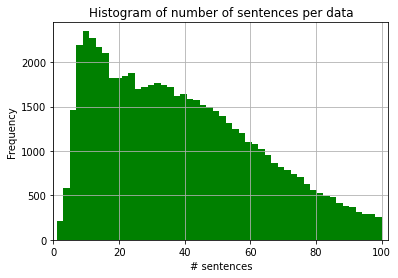

In [ ]:
# the histogram of the number of sentences per data
n, bins, patches = plt.hist(word_per_sent, 50, facecolor='g', alpha=1)
plt.xlabel('# sentences')
plt.ylabel('Frequency')
plt.title('Histogram of number of sentences per data')
plt.xlim(0, max(bins) + 2)
plt.ylim(0, max(n) + 100)
plt.grid(True)
plt.show()

## Change to word sequence

In [ ]:
def change_to_proper_format(clean_data):
    parsed_data = []
    for sents in clean_data:
        tokens = []
        for sent in sents:
            if len(tokens) != 0:
                # add a space between sentence
                tokens.append(['_', 'PU', 'O'])
            # Add sequence
            sequence = [ [w, p, 'I-ST'] for w, p, _, _ in sent]
            sequence[-1][-1] = 'E-ST'
            sequence[0][-1] = 'B-ST'
            tokens += sequence
        parsed_data.append(tokens)
    return parsed_data

In [ ]:
parsed_data = change_to_proper_format(clean_data)

In [ ]:
num_words = [len(d) for d in parsed_data] 

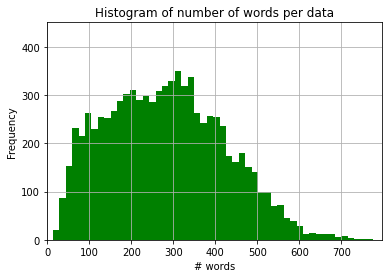

In [ ]:
# the histogram of the number of words per data
n, bins, patches = plt.hist(num_words, 50, facecolor='g', alpha=1)
plt.xlabel('# words')
plt.ylabel('Frequency')
plt.title('Histogram of number of words per data')
plt.xlim(0, max(bins) + 20)
plt.ylim(0, max(n) + 100)
plt.grid(True)
plt.show()

# Process all data

In [ ]:
import pickle

In [ ]:
def save_data(source):
    data, _, _, _, _, _ = read_data(source)
    clean_data, _, _ = prepare_data(data)
    parsed_data = change_to_proper_format(clean_data)
    print(f"Number of data ({source}):", len(parsed_data))
    with open(f'{store_path}/{source}.pkl', 'wb') as f:
        pickle.dump(parsed_data, f)

In [ ]:
save_data("train")
save_data("eval")
save_data("test")

100%|██████████| 7588/7588 [00:04<00:00, 1827.48it/s]


Number of data (train): 8315


  0%|          | 0/966 [00:00<?, ?it/s]

Number of data (eval): 784


100%|██████████| 966/966 [00:00<00:00, 5918.53it/s]


Number of data (test): 699


In [ ]:
8315 + 784 + 699

9798